pi/2 + pi*0 = 1.57
pi/2 + pi*1 = 4.71
pi/2 + pi*2 = 7.85
pi/2 + pi*3 = 11.00


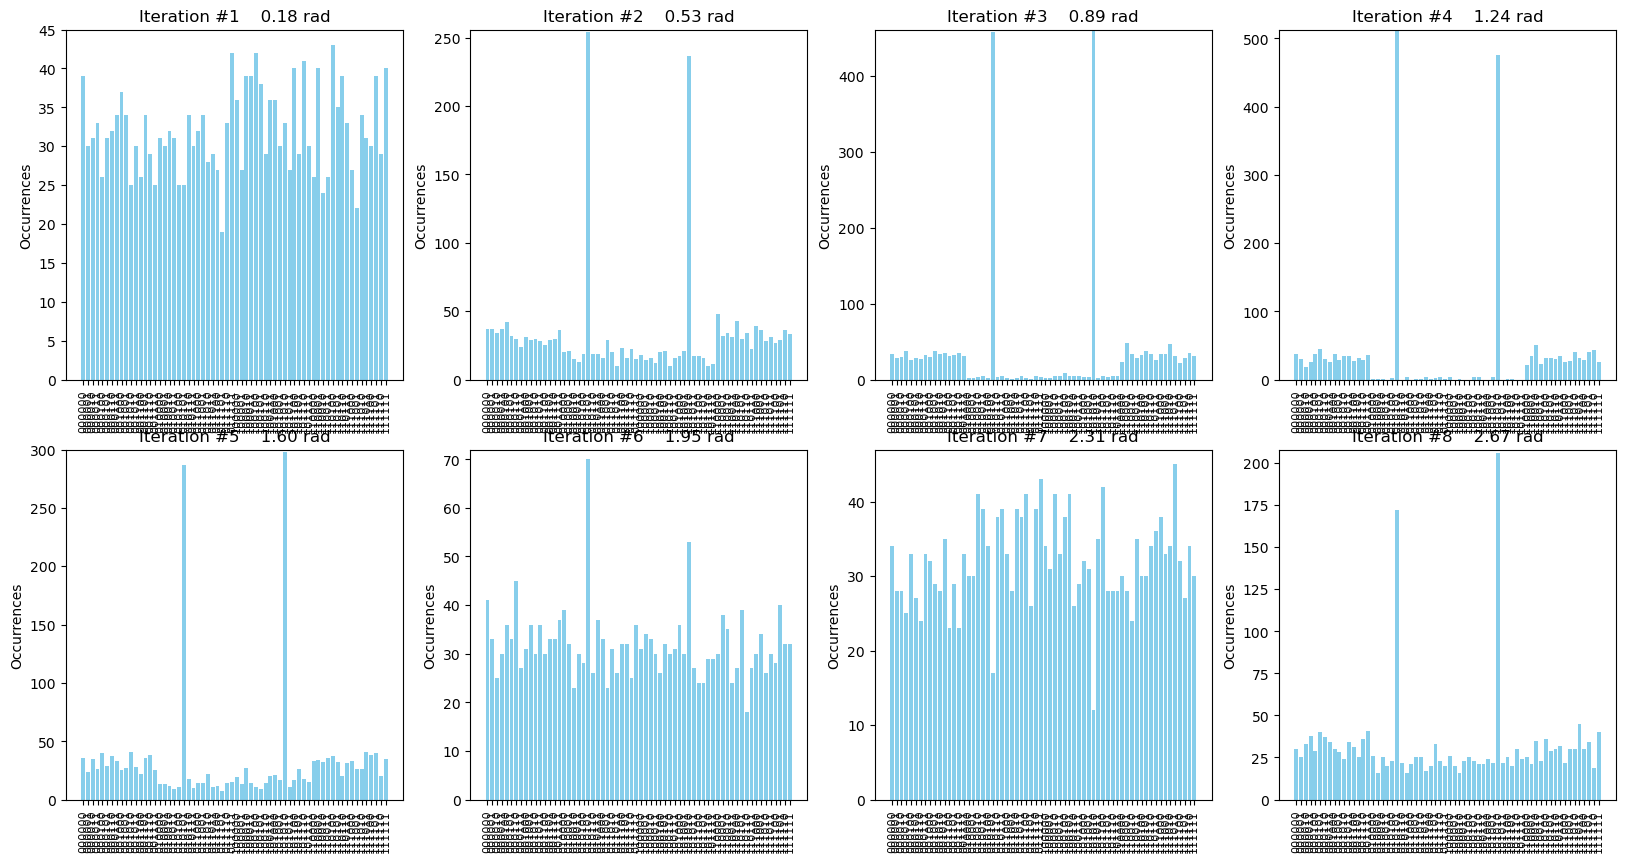

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math

NUM_QUBITS = 4
NUM_ITERATIONS = 8
#CLAUSE_LIST = [[0,1], [1,2], [2,3], [3,4], [4,5]]
CLAUSE_LIST = [[0,1], [1,2], [2,3]]
N = 2**NUM_QUBITS
m = 2**(NUM_QUBITS-len(CLAUSE_LIST))
theta = math.asin(np.sqrt(m/N))
for i in range(NUM_ITERATIONS//2):
    print(f"pi/2 + pi*{i} = {(math.pi/2 + math.pi*i):.2f}")

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

def get_oracle(qc, clause_list, clause_qubits, output_qubit):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return qc

def run_simulation():
    all_results = []
    for n in range(NUM_ITERATIONS):
        var_qubits = QuantumRegister(NUM_QUBITS, name='v')
        clause_qubits = QuantumRegister(len(CLAUSE_LIST), name='c')
        output_qubit = QuantumRegister(1, name='out')
        cbits = ClassicalRegister(NUM_QUBITS, name='cbits')
        qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

        # Initialize 'out0' in state |->
        qc.initialize([1, -1]/np.sqrt(2), output_qubit)

        # Initialize qubits in state |s>
        qc.h(var_qubits)
        qc.barrier()  # for visual separation

        def add_step():
            get_oracle(qc, CLAUSE_LIST, clause_qubits, output_qubit)
            qc.barrier()  # for visual separation
            qc.append(diffuser(4), [0,1,2,3])

        for _ in range(n):
            add_step()

        # Measure the variable qubits
        qc.measure(var_qubits, cbits)
        #qc.draw("mpl", filename=f"circuit_{n}.png")

        simulator = AerSimulator()
        transpiled_qc = transpile(qc, simulator)
        result = simulator.run(transpiled_qc, shots=2048).result()
        all_results.append(result.get_counts())

    return all_results

def get_all_bits_ordered_list():
    return [format(i, f"0{NUM_QUBITS}b") for i in range(2 ** NUM_QUBITS)]

def plot_stuff(results):
    # Get all possible basis states from number of qubits
    all_keys = get_all_bits_ordered_list()

    # Ensure all dictionaries have all the keys for the data
    completed_dicts = []
    for curr_result in results:
        completed_dicts.append({key: curr_result.get(key, 0) for key in all_keys})

    # Create subplots (2 rows, 4 columns)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.flatten()

    # Plot each dictionary as a bar graph
    for i, data in enumerate(completed_dicts):
        ax = axs[i]
        values = [data[k] for k in all_keys]
        ax.bar(all_keys, values, color="skyblue")
        ax.set_title(f"Iteration #{i+1}    {(2*i+1)*theta:.2f} rad")
        ax.set_ylim(0, max(values) + 2)
        ax.set_ylabel("Occurrences")

        # Rotate x-axis labels vertically and reduce font size
        ax.set_xticks(range(len(all_keys)))
        ax.set_xticklabels(all_keys, rotation="vertical", fontsize=8)
 


results = run_simulation()
plot_stuff(results)


0.17677669529663687


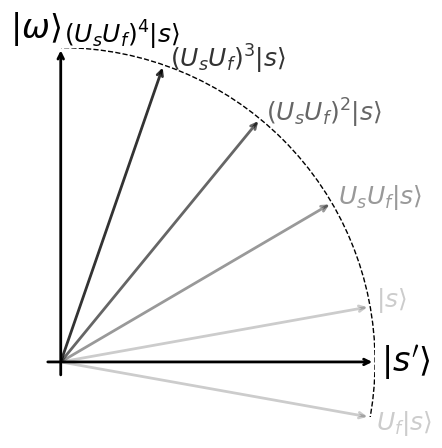

In [2]:
figure, axes = plt.subplots()
circle = plt.Circle((0,0),1,ls='--',fill=False)
axes.set_aspect(1)
axes.axis('off')
axes.add_artist(circle)

axes.annotate("",
    xy=(0,1), xytext=(0,-0.05),
    arrowprops=dict(arrowstyle="->", linewidth=2)
)
axes.text(-0.08, 1.0, r"$|\omega\rangle$", ha='center', va='bottom', fontsize=24)

axes.annotate("",
    xy=(1,0), xytext=(-0.05,0),
    arrowprops=dict(arrowstyle="->", linewidth=2)
)
axes.text(1.02, 0, r"$|s'\rangle$", ha='left', va='center', fontsize=24)

phi = 1/np.sqrt(2**5)
print(phi)

axes.annotate("",
    xy=(np.cos(phi), np.sin(phi)), xytext=(0,0),
    arrowprops=dict(arrowstyle="->", linewidth=2, alpha=0.2)
)
axes.text(np.cos(phi)+0.02, np.sin(phi)+0.02, r"$|s\rangle$", ha='left', va='center', fontsize=18, alpha=0.2)

axes.annotate("",
    xy=(np.cos(phi), -np.sin(phi)), xytext=(0,0),
    arrowprops=dict(arrowstyle="->", linewidth=2, alpha=0.2)
)
axes.text(np.cos(phi)+0.02, -np.sin(phi)-0.02, r"$U_f|s\rangle$", ha='left', va='center', fontsize=18, alpha=0.2)

axes.annotate("",
    xy=(np.cos(3*phi), np.sin(3*phi)), xytext=(0,0),
    arrowprops=dict(arrowstyle="->", linewidth=2, alpha=0.4)
)
axes.text(np.cos(3*phi)+0.02, np.sin(3*phi)+0.02, r"$U_sU_f|s\rangle$", ha='left', va='center', fontsize=18, alpha=0.4)

axes.annotate("",
    xy=(np.cos(5*phi), np.sin(5*phi)), xytext=(0,0),
    arrowprops=dict(arrowstyle="->", linewidth=2, alpha=0.6)
)
axes.text(np.cos(5*phi)+0.02, np.sin(5*phi)+0.02, r"$(U_sU_f)^2|s\rangle$", ha='left', va='center', fontsize=18, alpha=0.6)

axes.annotate("",
    xy=(np.cos(7*phi), np.sin(7*phi)), xytext=(0,0),
    arrowprops=dict(arrowstyle="->", linewidth=2, alpha=0.8)
)
axes.text(np.cos(7*phi)+0.02, np.sin(7*phi)+0.02, r"$(U_sU_f)^3|s\rangle$", ha='left', va='center', fontsize=18, alpha=0.8)

axes.annotate("",
    xy=(np.cos(9*phi), np.sin(9*phi)), xytext=(0,0),
    arrowprops=dict(arrowstyle="->", linewidth=2, alpha=1)
)
axes.text(np.cos(9*phi)+0.03, np.sin(9*phi)+0.04, r"$(U_sU_f)^4|s\rangle$", ha='left', va='center', fontsize=18, alpha=1)

#plt.xlim(0,1)
plt.ylim(-np.sin(phi),1)
plt.show()
